# This notebook calculates the normal vector for every coastline grid cell 

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

import cartopy.feature as cfeature

In [3]:
# load classification CSV:
numerical_df = pd.read_csv('cell_geo_type.csv')

In [4]:
# define a function to calculate the normal vector angle
def calculate_normal_vector_angle(matrix):
    
    # define direction vectors for the 24 surrounding cells
    directions = [(dy, dx) for dy in range(-2, 3) for dx in range(-2, 3) if (dx, dy) != (0, 0)]
    
    normal_x = 0
    normal_y = 0
    
    for (dy, dx), value in zip(directions, matrix.flatten()):
        weight = 0.5 if max(abs(dx), abs(dy)) == 2 else 1
        if value == 1:
            normal_x += dx * weight
            normal_y += dy * weight
        elif value == 0:
            normal_x -= dx * weight
            normal_y -= dy * weight
    
    # calculate the angle in degrees
    angle = np.degrees(np.arctan2(normal_y, normal_x)) % 360
    return angle

In [5]:
# perform normal vector calculations

# initialize lists
positions = []
u_list = []
v_list = []

# initialize output df
u_df = numerical_df.copy()
u_df[:] = np.nan
v_df = u_df.copy()

# for each row
for i in tqdm(range(2, numerical_df.shape[0] - 2)):
    # for each column
    for j in range(2, numerical_df.shape[1] - 2):
        if numerical_df.iat[i, j] == 2:
            
            # get 5x5 matrix around current grid cell
            matrix = numerical_df.iloc[i-2:i+3, j-2:j+3].values
            
            # calculate the angle of the normal vector
            angle = calculate_normal_vector_angle(matrix)
            
            # calculate the vector components
            u = np.cos(np.radians(angle))
            v = np.sin(np.radians(angle))
            
            # save vector components in the output dataframe as a tuple:
            u_df.iat[i, j] = u
            v_df.iat[i, j] = v
            
            # store the position and the vector components
            positions.append((i, j))
            u_list.append(u)
            v_list.append(v)

100%|██████████| 156/156 [00:03<00:00, 47.52it/s]


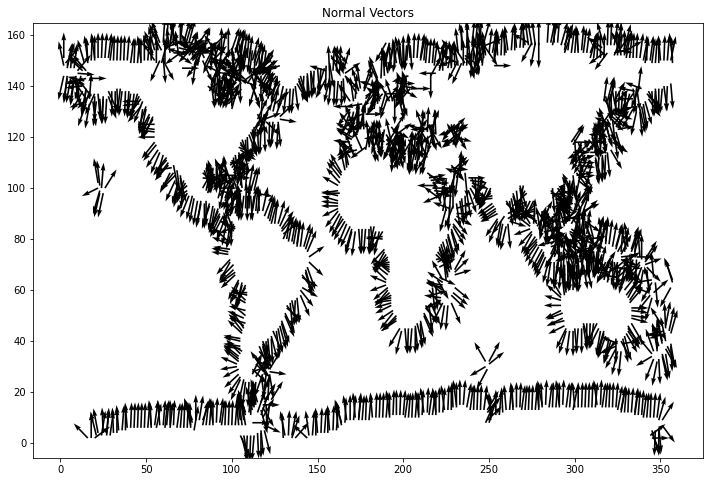

In [12]:
# convert positions to X and Y arrays
positions = np.array(positions)
X, Y = positions[:, 1], positions[:, 0]

# plot the vectors using plt.quiver
plt.figure(figsize=(12, 8))
plt.quiver(X[::2], Y[::2], u_list[::2], v_list[::2], angles = 'xy', scale_units = 'xy', scale = 0.1)

plt.title('Normal Vectors')
plt.show()

In [14]:
# save u_df and v_df as CSV
u_df.to_csv('u_df.csv', index=False)
v_df.to_csv('v_df.csv', index=False)